# Stratification Using Odds Modeling

In any kind of wildlife modeling we are confronted with a simple problem - wildlife are usually distributed heterogeneously throughout space. The simplest sense of this is that different areas present different kinds of habitat - some of which may be useful to the species in question. Recognizing this heterogeneity is useful for two reasons (amongst many others):

1. It helps us recognize and remove biases we may otherwise miss.
2. It helps us make better use of our efforts.

### Removing Biases

Suppose I'm interested in some kind of global statistic - like the total abundance of a species of fish in an area. It may seem that I could obtain an answer to this question by simply randomly sampling the area, using a relative index of abundance like CPUE to obtain an average abundance per $km^2$ and then extrapolate this over the full area, but there is a big danger here. This kind of average over a random sample in space works *only* if the error term is uniform throughout space. If it isn't you'll end up with biases just because some error terms are sampled more heavily than others. 

In general many fish populations seem to follow log normal or even more extremely right skewed distributions where the mean of the distribution is definitely related to the variance. And so, if there is heterogeneity in the means you can bet there will be spatial patterns to the variance as well. 

Without some kind of stratification to try and find areas with stable error terms we're going to be incorporating biases all over the place without knowing it. 

### Making Better Use of Effort

Stratification to help find these spatial patterns in variance can do one of two things:

- Our stratification helps separate different aspects of our overall distribution and actually reduces the error per stratum as compared to the whole
- Our stratification allows us to separate areas with high variance from areas with low variance

If we're making an abundance estimate of the form:

$$B=\sum_{r}\psi_{r}\bullet A_{r}$$

where $r$ is a stratum (specific region), $\psi_{r}$ is the average CPUE (expressed as biomass / $km^2$) in that region, and $A_{r}$ is the area of that stratum then the variance in our estimate is:

$$\sigma_B^2=\sum_{r}A_{r}^2\frac{\sigma^2_r}{n_r}$$

This means that our overall variance is controlled by how much effort we put into resolve the CPUE in each stratum. If we can separate stratum so that our $\sigma^2_r$ decreases significantly then the effort we need can decrease as well. And if we can isolate areas with high $\sigma^2_r$ then we can focus most of our efforts there. 

In other words our stratification helps us understand how to spatially distribute our effort in order to get the best variance estimates while also potentially reducing the overall effort required. 

In either case we can say one stratification is better than another if the overall effort required to acheive the same variance is lower in the first case than the latter. 

## Chicken and the Egg

The question is now - how to choose strata? The issue is that in order to get a sense of how much a particular species likes a specific habitat it would seem that one would need some kind of abundance estimate. Yet to get an abundance estimate effectively strata would be helpful. Bit of a chicken and the egg kind of problem here. 

However, what if we based our stratification not on abundance estimates, but on behavior? Using thinking along the lines of what's outlined here - [Preference Modeling](https://github.com/networkearth/mirrorverse/wiki/The-Theory#preference-modeling). The question would be how to take the preferences and actually form spatial clusters. 

## Spatial Clustering Using Preference Modeling

The blurb on [Preference Modeling](https://github.com/networkearth/mirrorverse/wiki/The-Theory#preference-modeling) identifies two issues when creating strata.

1. Identifying areas of interest to species.
2. Separating areas that could be different just because their connectivity is not strong (even if otherwise they are identical).

The first case is relatively simple from our preference modeling perspective - areas that have similar strengths of preference could be considered similar because all else held equal, we should expect similar amount of individuals there.

However it is the second part that is tricky - how do we identify connectivity? 

Remember that our initial preference model can be expressed as a matrix $P$ of dimensions $(m,m)$ ($m$ is the number of hex cells we are considering) where each element $p_{i,j}$ gives us the likelihood that a fish passes from hex $j$ to hex $i$. Therefore the columns must sum to 1 in order to conserve our fish. 

Now obviously the fish is only considering local choices so only the neighboring hexes will be represented. But suppose we took this matrix and multiplied it by a vector $[1, 0, 0, ..., 0]$. This would then tell us where fish from hex $1$ go in a first timestep. If we took the result and multiplied it by our matrix again, we'd see where those fish go in the next timestep, and so on for as many timesteps as we like. In other words $P^n\bullet [1,0,0,...,0]$ gives us where the fish from hex 1 show up at timepoint $n$. 

In general then $P^n \bullet I = P^n$ gives us a matrix where each column $j$ represents the distribution of fish from hex cell $j$. In turn this means that each row of $P^n$ represents where hex $i$ has gotten its fish from. And with this we can define a kind of connectivity! Because if two rows $i$ and $k$ are the same in this matrix it means we'd expect their abundance to be identical too because they are receiving fish from the same places in the same proportions. As vectors $i$ and $k$ get more dissimilar we'd expect there abundances to become more and more independent even if they have a similar amount of preferentiability (indicated by the sum of their rows in $P^n$).

I.e. this matrix $P^n$ gives us the information we need to determine how similar or distant two hexes are. Which means if we are precise about our "distance" we can use agglomerative clustering to them build our strata!

Let's define our distance as:

$$d_{i,k} = \frac{r_{i,k}}{\cos{\theta_{i,k}}}$$

where $r_{i,k}$ is the ratio of the two sums of rows (chosing whichever of $i$ or $k$ is larger to be the numerator of that ratio) and $\theta_{i,k}$ is the angle between the two rows. This'll mean that as the angle gets larger our fraction blows up and as the ratio gets larger our fraction increases as well.

From here we should be able to use agglomerative clustering to the define our strata. 

# Trying it Out

## Building our Odds Model

As with the preferences modeling blurb we're going to use a super simple, single feature odds model to test this out. 

In [1]:
import os
import h3
import pandas as pd
import numpy as np
import plotly.express as px
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold


from mirrorverse.tree import DecisionTree
from mirrorverse.chinook import utils
from mirrorverse.warehouse.etls.dimensions.spatial import get_coords
from mirrorverse.chinook.train import get_elevation

pd.options.mode.chained_assignment = None

os.environ["DATABASE_URL"] = "sqlite:////workspaces/mirrorverse/mirrorverse.db"

### Define Our Decision Tree

In [2]:
class HabitatMovementChoiceBuilder:
    """
    Habitat Movement choice builder for Chinook salmon.
    """

    STATE = ["h3_index"]
    CHOICE_STATE = []
    COLUMNS = [
        "h3_index",
        "elevation",
    ]

    def __init__(self, enrichment):
        self.neighbors = enrichment["neighbors"]
        self.elevation = enrichment["elevation"]

    def __call__(self, state, choice_state):
        h3_index = state["h3_index"]

        if h3_index not in self.neighbors:
            utils.find_neighbors(h3_index, self.neighbors)
        neighbors = self.neighbors.get(h3_index)

        choices = pd.DataFrame(neighbors, columns=["h3_index"])

        choices = choices.merge(self.elevation, on="h3_index", how="inner")

        return choices

class HabitatMovement(DecisionTree):
    """
    Habitat Movement model for Chinook salmon.
    """

    BUILDERS = [HabitatMovementChoiceBuilder]
    FEATURE_COLUMNS = [
        "elevation",
    ]
    OUTCOMES = ["h3_index"]
    BRANCHES = {}
    PARAM_GRID = {"n_estimators": [10, 20], "min_samples_leaf": [50, 100]}
    CV = KFold(n_splits=5, shuffle=True, random_state=42)

    # pylint: disable=unused-argument
    @staticmethod
    def get_identifier(choice):
        """
        Input:
        - choice (dict): the choice made

        Does nothing
        """

    @staticmethod
    def update_branch(choice, choice_state):
        """
        Input:
        - choice (dict): the choice made
        - choice_state (dict): the state of the choice
            thus far

        Updates the choice with a "h3_index" key.
        """
        choice_state["h3_index"] = choice["h3_index"]

    @staticmethod
    def _stitch_selection(choices, selection):
        """
        Input:
        - choices (pd.DataFrame): the choices possible
        - selection (dict): the selection made

        Returns the choices with a "selected" column.
        Selection is based on the h3_index.
        """
        choices["selected"] = choices["h3_index"] == selection
        return choices

### Get Our Data

In [3]:
from mirrorverse.chinook.states import load_tag_tracks

RESOLUTION = 4

data = load_tag_tracks('../../pipelines/chinook/data/tag_tracks.csv')
data = data[data["ptt"] != "129843"]

states = []
choice_states = []
selections = []
identifiers = []

for ptt in data["ptt"].unique():
    tag_data = data[data["ptt"] == ptt].sort_values("date", ascending=True)
    rows = [r for _, r in tag_data.iterrows()]
    for start, end in zip(rows[:-1], rows[1:]):
        state = {"h3_index": h3.geo_to_h3(start["lat"], start["lon"], RESOLUTION)}
        choice_state = {}
        selection = h3.geo_to_h3(end["lat"], end["lon"], RESOLUTION)
        
        states.append(state)
        choice_states.append(choice_state)
        selections.append(selection)
        identifiers.append(ptt)

In [4]:
enrichment = {
    "elevation": get_elevation('../../pipelines/chinook/data/bathymetry.csv'),
    "neighbors": {},
}

### Train the Model

In [5]:
decision_tree = HabitatMovement(enrichment=enrichment)

In [6]:
model_data = decision_tree._build_model_data(
    states,
    choice_states,
    selections,
    identifiers,
    quiet=True,
)
print(model_data.shape)
model_data.head()

(141221, 5)


h3_index    elevation  selected  _decision _identifier
0  840c9bdffffffff -2621.929547     False          0      133395
1  8422cb7ffffffff -3534.997213     False          0      133395
2  840c9b5ffffffff -3318.522810     False          0      133395
3  840c9a9ffffffff -3411.695086      True          0      133395
4  840c985ffffffff -2849.268381     False          0      133395

In [7]:
decision_tree.train_model(
    states,
    choice_states,
    selections,
    identifiers,
    N=20,
    quiet=True,
)

100%|██████████| 20/20 [03:35<00:00, 10.75s/it]


## Building Our Preferences Matrix

Note here we're going to limit ourselves to hexes seen in training just because that lines up reasonably well with the Gulf of Alaska (GOA) survey data we'll use later.

In [8]:
seen_in_training = set(model_data["h3_index"])

seen_in_elevation = set(enrichment["elevation"]["h3_index"])

seen_in_both = list(seen_in_training.intersection(seen_in_elevation))
len(seen_in_both)

1436

In [9]:
state = {}
choice_state = {}

full_choice_df = []
for h3_index in tqdm(seen_in_both):
    state = {'h3_index': h3_index}
    choice_state = {}
    choices = decision_tree.get_choices(state, choice_state)
    choices["source_h3_index"] = h3_index
    full_choice_df.append(choices)

full_choice_df = pd.concat(full_choice_df)
print(full_choice_df.shape)
full_choice_df.head()

100%|██████████| 1436/1436 [00:06<00:00, 224.78it/s]

(28162, 3)


h3_index  elevation  source_h3_index
0  840cd39ffffffff -93.296224  840cd39ffffffff
1  840cd05ffffffff -82.981646  840cd39ffffffff
2  840cd1dffffffff -79.168385  840cd39ffffffff
3  840cdedffffffff -92.942373  840cd39ffffffff
4  840cd07ffffffff -88.422819  840cd39ffffffff

In [10]:
full_choice_df['utility'] = decision_tree.model.predict(full_choice_df[decision_tree.FEATURE_COLUMNS])
full_choice_df.head()

h3_index  elevation  source_h3_index   utility
0  840cd39ffffffff -93.296224  840cd39ffffffff  2.645625
1  840cd05ffffffff -82.981646  840cd39ffffffff  0.029228
2  840cd1dffffffff -79.168385  840cd39ffffffff  1.599303
3  840cdedffffffff -92.942373  840cd39ffffffff  1.488173
4  840cd07ffffffff -88.422819  840cd39ffffffff  0.202938

In [11]:
full_choice_df = full_choice_df[full_choice_df['h3_index'].isin(seen_in_both)]

full_choice_df['total_utility'] = full_choice_df.groupby('source_h3_index')['utility'].transform('sum')
full_choice_df['probability'] = full_choice_df['utility'] / full_choice_df['total_utility']
full_choice_df.head()

h3_index  elevation  source_h3_index   utility  total_utility  \
0  840cd39ffffffff -93.296224  840cd39ffffffff  2.645625      16.467028   
1  840cd05ffffffff -82.981646  840cd39ffffffff  0.029228      16.467028   
2  840cd1dffffffff -79.168385  840cd39ffffffff  1.599303      16.467028   
3  840cdedffffffff -92.942373  840cd39ffffffff  1.488173      16.467028   
4  840cd07ffffffff -88.422819  840cd39ffffffff  0.202938      16.467028   

   probability  
0     0.160662  
1     0.001775  
2     0.097122  
3     0.090373  
4     0.012324

In [14]:
diffusion_matrix = np.zeros((len(seen_in_both), len(seen_in_both)))
for i, source_h3_index in tqdm(enumerate(seen_in_both)):
    sink_df = full_choice_df[full_choice_df['source_h3_index'] == source_h3_index]
    probs = sink_df.set_index('h3_index')['probability'].to_dict()
    for j, h3_index in enumerate(seen_in_both):
        if h3_index in probs:
            diffusion_matrix[j, i] = probs[h3_index]

diffusion_matrix = np.linalg.matrix_power(diffusion_matrix, 30)

1436it [00:03, 458.43it/s]


In [15]:
rows = []
for h3_index, row in zip(seen_in_both, diffusion_matrix):
    rows.append({'h3_index': str(h3_index), 'row_weight': sum(row)})

df = pd.DataFrame(rows)
df['lat'] = df['h3_index'].apply(lambda x: h3.h3_to_geo(x)[0])
df['lon'] = df['h3_index'].apply(lambda x: h3.h3_to_geo(x)[1])
df['log_row_weight'] = np.log(df['row_weight'])
fig = px.scatter_geo(
    df,
    lat='lat',
    lon='lon',
    color='log_row_weight',
)
fig.update_layout(autosize=True, height=600, geo=dict(center=dict(lat=58, lon=-150), projection_scale=6))
fig

We'll now limit this to the GOA survey area.

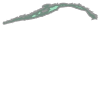

In [16]:
df = gpd.read_file('stratification/akgfmaps_shapefiles_goa_20240410/survey_strata.shp')
goa_geom = df['geometry'].values[0]
for geometry in df['geometry']:
    goa_geom = goa_geom.union(geometry)
goa_geom

In [17]:
contained = []
for h3_index in tqdm(seen_in_both):
    contained.append(
        goa_geom.contains(Point(reversed(h3.h3_to_geo(h3_index))))
    )
contained = np.array(contained)

100%|██████████| 1436/1436 [00:07<00:00, 183.53it/s]


In [18]:
contained_seen_in_both = np.array(seen_in_both)[contained]
contained_diffusion_matrix = diffusion_matrix[contained,:][:,contained]
contained_diffusion_matrix.shape

(219, 219)

And let's see what we got!

In [19]:
rows = []
for h3_index, row in zip(contained_seen_in_both, contained_diffusion_matrix):
    rows.append({'h3_index': str(h3_index), 'row_weight': sum(row)})

df = pd.DataFrame(rows)
df['lat'] = df['h3_index'].apply(lambda x: h3.h3_to_geo(x)[0])
df['lon'] = df['h3_index'].apply(lambda x: h3.h3_to_geo(x)[1])
df['log_row_weight'] = np.log(df['row_weight'])
fig = px.scatter_geo(
    df,
    lat='lat',
    lon='lon',
    color='log_row_weight',
)
fig.update_layout(autosize=True, height=600, geo=dict(center=dict(lat=58, lon=-150), projection_scale=6))
fig

## Creating Our Strata

First step is building our distances.

In [20]:
angle_matrix = np.zeros((len(contained_seen_in_both), len(contained_seen_in_both)))
ratio_matrix = np.zeros((len(contained_seen_in_both), len(contained_seen_in_both)))
for i in tqdm(range(len(contained_seen_in_both))):
    for j in range(len(contained_seen_in_both)):
        u = contained_diffusion_matrix[i,:]
        v = contained_diffusion_matrix[j,:]
        c = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)
        angle = np.arccos(np.clip(c, -1, 1))
        angle_matrix[i,j] = angle
        ratio = np.sum(u)/np.sum(v)
        ratio = ratio if ratio >= 1 else 1 / ratio
        ratio_matrix[i,j] = ratio


distance_matrix = np.clip(1 / np.cos(angle_matrix), 0, 1000) * ratio_matrix

100%|██████████| 219/219 [00:01<00:00, 197.91it/s]


In [21]:
N = 6

clustering = AgglomerativeClustering(n_clusters=N, metric="precomputed", connectivity=None, linkage="complete")
clustering.fit(distance_matrix)

max_distance = 0
for label in range(N):
    distance = distance_matrix[clustering.labels_ == label,:][:,clustering.labels_ == label].max()
    max_distance = max(max_distance, distance)
max_distance

648.7755353684777

In [22]:
rows = []
for h3_index, cluster in zip(contained_seen_in_both, clustering.labels_):
    rows.append({'h3_index': str(h3_index), 'cluster': str(cluster)})

cluster_df = pd.DataFrame(rows)
cluster_df['lat'] = cluster_df['h3_index'].apply(lambda x: h3.h3_to_geo(x)[0])
cluster_df['lon'] = cluster_df['h3_index'].apply(lambda x: h3.h3_to_geo(x)[1])
fig = px.scatter_geo(
    cluster_df,
    lat='lat',
    lon='lon',
    color='cluster',
)
fig.update_layout(autosize=True, height=600, geo=dict(center=dict(lat=58, lon=-150), projection_scale=6))
fig

## The Proof is in the Pudding

Is this actually helpful at all?

### Load in Some Survey Data

In [23]:
trawl = pd.read_csv('stratification/CATCH AND HAUL DATA.csv')
index = trawl[
    ['Date and time', 'Start latitude (decimal degrees)', 'Start longitude (decimal degrees)']
].drop_duplicates().reset_index(drop=True).reset_index()
trawl = trawl.merge(index, on=['Date and time', 'Start latitude (decimal degrees)', 'Start longitude (decimal degrees)'])
trawl = trawl[
    [
        'Survey year', 'Start latitude (decimal degrees)', 'Start longitude (decimal degrees)', 
        'Weight CPUE (kg/km2)', 'Stratum ID', 'index', "Taxon scientific name"
    ]
].rename({
    'Survey year': 'year',
    'Start latitude (decimal degrees)': 'lat',
    'Start longitude (decimal degrees)': 'lon',
    'Weight CPUE (kg/km2)': 'cpue',
    "Taxon scientific name": "species"
}, axis=1)
trawl['cpue'] = trawl['cpue'] * (trawl['species'] == 'Oncorhynchus tshawytscha')
trawl = trawl.groupby(['index', 'lat', 'lon'])['cpue'].sum().reset_index()
trawl.head()

index       lat        lon  cpue
0      0  58.57066 -139.56427   0.0
1      1  58.69181 -140.25937   0.0
2      2  58.59370 -140.01416   0.0
3      3  59.52838 -142.07294   0.0
4      4  56.22929 -135.30210   0.0

In [24]:
trawl['log_cpue'] = np.log(trawl['cpue'] + 1)
fig = px.scatter_geo(
    trawl,
    lat='lat',
    lon='lon',
    color='log_cpue',
)
fig.update_layout(autosize=True, height=600, geo=dict(center=dict(lat=58, lon=-150), projection_scale=6))
fig

### Join Our Strata

In [25]:
class Strata:
    def __init__(self, h3_indices, label):
        self.h3_indices = h3_indices
        self.label = label

        h3_geoms = [Polygon(get_coords(h3_index)) for h3_index in h3_indices]
        self.geom = h3_geoms[0]
        for h3_geom in h3_geoms[1:]:
            self.geom = self.geom.union(h3_geom)

        self.area = h3.hex_area(4, 'km^2') * len(h3_indices)

    def contains(self, lat, lon):
        return self.geom.contains(Point(lon, lat))

In [26]:
strata = {}
for label in range(N):
    h3_indices = cluster_df[(cluster_df['cluster'] == str(label))]['h3_index']
    if h3_indices.shape[0] > 0:
        strata[label] = Strata(h3_indices, label)

In [27]:
def get_stratum(lat, lon, strata):
    for label, stratum in strata.items():
        if stratum.contains(lat, lon):
            return label
    return -1

trawl['psat_stratum'] = trawl.apply(lambda x: get_stratum(x['lat'], x['lon'], strata), axis=1)
trawl.head()

index       lat        lon  cpue  log_cpue  psat_stratum
0      0  58.57066 -139.56427   0.0       0.0             4
1      1  58.69181 -140.25937   0.0       0.0             4
2      2  58.59370 -140.01416   0.0       0.0             4
3      3  59.52838 -142.07294   0.0       0.0             4
4      4  56.22929 -135.30210   0.0       0.0             5

In [28]:
trawl = trawl[trawl['psat_stratum'] != -1]

In [29]:
trawl['psat_area'] = trawl['psat_stratum'].apply(lambda x: strata[x].area)

In [30]:
trawl['whole_stratum'] = 1
trawl['whole_area'] = trawl[['psat_stratum', 'psat_area']].drop_duplicates()['psat_area'].sum()

In [31]:
trawl.head()

index       lat        lon  cpue  log_cpue  psat_stratum     psat_area  \
0      0  58.57066 -139.56427   0.0       0.0             4  49569.059456   
1      1  58.69181 -140.25937   0.0       0.0             4  49569.059456   
2      2  58.59370 -140.01416   0.0       0.0             4  49569.059456   
3      3  59.52838 -142.07294   0.0       0.0             4  49569.059456   
4      4  56.22929 -135.30210   0.0       0.0             5  31865.823936   

   whole_stratum     whole_area  
0              1  387700.857888  
1              1  387700.857888  
2              1  387700.857888  
3              1  387700.857888  
4              1  387700.857888

### Comparing Variances

We'll start by making sure our original distribution is actually uniform.

In [32]:
N = 50

whole_var = []
strata_var = []

for _ in range(N):
    total_samples = 5000
    rebalanced_trawl = []
    for psat_stratum in trawl['psat_stratum'].unique():
        df = trawl[trawl['psat_stratum'] == psat_stratum]
        num_samples = int(round(total_samples * df['psat_area'].values[0] / df['whole_area'].values[0]))
        rebalanced_trawl.append(
            df.sample(num_samples, replace=True)
        )
    rebalanced_trawl = pd.concat(rebalanced_trawl)

    rebalanced_trawl['prob'] = rebalanced_trawl['cpue'] > 0
    df = rebalanced_trawl.groupby('whole_stratum').agg({'prob': 'mean', 'whole_area': 'mean'}).reset_index().merge(
        rebalanced_trawl[rebalanced_trawl['cpue'] > 0].groupby('whole_stratum').agg({'cpue': 'var'}).reset_index(), how='left'
    ).fillna(0.0)
    df['fraction_area'] = df['whole_area'] / df['whole_area'].sum()
    df['reweighted_effort'] = rebalanced_trawl.shape[0] * df['fraction_area']
    df['var'] = df['cpue'] * (df['prob'] ** 2) * (df['whole_area'] ** 2) / (df['reweighted_effort'] * df['prob'])
    whole_var.append(df['var'].sum())

    rebalanced_trawl['prob'] = rebalanced_trawl['cpue'] > 0
    df = rebalanced_trawl.groupby('psat_stratum').agg({'prob': 'mean', 'psat_area': 'mean'}).reset_index().merge(
        rebalanced_trawl[rebalanced_trawl['cpue'] > 0].groupby('psat_stratum').agg({'cpue': 'var'}).reset_index(), how='left'
    ).fillna(0.0)
    df['fraction_area'] = df['psat_area'] / df['psat_area'].sum()
    df['reweighted_effort'] = rebalanced_trawl.shape[0] * df['fraction_area']
    df['var'] = df['cpue'] * (df['prob'] ** 2) * (df['psat_area'] ** 2) / (df['reweighted_effort'] * df['prob'])
    strata_var.append(df['var'].sum())

whole_var = np.array(whole_var)
strata_var = np.array(strata_var)
ratios = strata_var/whole_var
px.histogram(ratios)

    

Cool! Seems like these strata are indeed helpful!